# reaction-network (Demo Notebook): Networks

### Author: Matthew McDermott
Last Updated: 12/07/21

The code provided in this notebook is an updated walkthrough of the first example in the accompanying manuscript (see citation below). The refactored `reaction-network` package contains similar code to what was released with the manuscript; however, many processes/functions are now separated into their own defined classes/methods. For a look at the previous demo notebook (which also contained some of the raw results that went into the manuscript), please check out the _archived_ folder.

**If you use this code or Python package in your work, please consider citing the following paper:**

McDermott, M. J., Dwaraknath, S. S., and Persson, K. A. (2021). A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis. 
Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-23339-x

### Imports

In [2]:
import logging 

from pymatgen.ext.matproj import MPRester
from rxn_network.enumerators.basic import BasicEnumerator, BasicOpenEnumerator
from rxn_network.enumerators.minimize import MinimizeGibbsEnumerator, MinimizeGrandPotentialEnumerator
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from rxn_network.thermo.chempot_diagram import ChemicalPotentialDiagram

from rxn_network.costs.softplus import Softplus
from pymatgen.core.composition import Composition, Element
from rxn_network.entries.entry_set import GibbsEntrySet
from rxn_network.network.network import ReactionNetwork
from rxn_network.entries.nist import NISTReferenceEntry
from rxn_network.reactions.computed import ComputedReaction
from rxn_network.reactions.reaction_set import ReactionSet
from rxn_network.reactions.open import OpenComputedReaction
from rxn_network.network.entry import NetworkEntry, NetworkEntryType
from rxn_network.network.visualize import plot_network_on_graphistry, plot_network
from rxn_network.pathways.solver import PathwaySolver

import graphistry
import graph_tool.all as gt

logging.info("Logging initialized")

%load_ext autoreload
%autoreload 2

### Downloading and modifying entries

First, we acquire entries for phases in the Y-Mn-O-Li-Cl-C chemical system from the Materials Project (MP), a computed materials database containing calculations for over 130,000 materials.

In [3]:
with MPRester() as mpr:  # insert your Materials Project API key here if it's not stored in .pmgrc.yaml
    entries = mpr.get_entries_in_chemsys("Y-Mn-O-Li-Cl-C", inc_structure="final")

  0%|          | 0/848 [00:00<?, ?it/s]

The `GibbsEntrySet` class allows us to automatically convered `ComputedStructureEntry` objects downloaded from the MP database into `GibbsComputedEntry` objects, where DFT-calculated energies have been converted to machine learning (ML)-estimated equivalent values of the Gibbs free energies of formation, $\Delta G_f$ for all entries at the specified temperature. 

For more information, check out the citation in the documentation for `GibbsComputedEntry`.

In [4]:
temp = 900  # Units: Kelvin
entry_set = GibbsEntrySet.from_entries(entries, temp)

We can print the entries by calling `.entries` or `.entries_list`:

In [5]:
entry_set.entries

{GibbsComputedEntry | mp-1001581 | Li1 C6 (LiC6)
 Gibbs Energy (900 K) = -0.1809,
 GibbsComputedEntry | mp-1001594 | C48 O36 (C4O3)
 Gibbs Energy (900 K) = -57.1177,
 GibbsComputedEntry | mp-1001790 | Li1 O3 (LiO3)
 Gibbs Energy (900 K) = 0.1071,
 GibbsComputedEntry | mp-1002572 | Li4 Mn4 O8 (LiMnO2)
 Gibbs Energy (900 K) = -25.9343,
 GibbsComputedEntry | mp-1003313 | Li4 Mn6 O12 (Li2Mn3O6)
 Gibbs Energy (900 K) = -33.9276,
 GibbsComputedEntry | mp-1003315 | Li4 Mn16 O32 (LiMn4O8)
 Gibbs Energy (900 K) = -72.1966,
 GibbsComputedEntry | mp-1003549 | Li1 Mn16 O32 (LiMn16O32)
 Gibbs Energy (900 K) = -63.1448,
 GibbsComputedEntry | mp-1003637 | Li1 Mn3 O6 (LiMn3O6)
 Gibbs Energy (900 K) = -14.2671,
 GibbsComputedEntry | mp-1003769 | Li3 Mn4 O8 (Li3Mn4O8)
 Gibbs Energy (900 K) = -23.2175,
 GibbsComputedEntry | mp-1004373 | Li4 Mn4 O8 (LiMnO2)
 Gibbs Energy (900 K) = -10.5488,
 GibbsComputedEntry | mp-1004532 | C16 Cl64 (CCl4)
 Gibbs Energy (900 K) = -13.3274,
 GibbsComputedEntry | mp-100476

The `GibbsEntrySet` class has many helpful functions, such as the following `filter_by_stability()` function, which automatically removes entries which are a specified energy per atom above the convex hull of stability:

In [9]:
entry_set = entry_set.filter_by_stability(0.0)

In this case, we remove all non-stable entries from the entry set, which greatly reduces the combinatorial complexity of the system:

In [11]:
entry_set.entries

{GibbsComputedEntry | mp-1004532 | C16 Cl64 (CCl4)
 Gibbs Energy (900 K) = -13.3274,
 GibbsComputedEntry | mp-1008394 | Cl4 (Cl2)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1018134 | Li3 (Li)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1021323 | Li1 C12 (LiC12)
 Gibbs Energy (900 K) = -0.8730,
 GibbsComputedEntry | mp-1097867 | Li6 Mn12 O24 (LiMn2O4)
 Gibbs Energy (900 K) = -65.0928,
 GibbsComputedEntry | mp-1172875 | Mn32 O48 (Mn2O3)
 Gibbs Energy (900 K) = -121.0665,
 GibbsComputedEntry | mp-1182086 | C4 O8 (CO2)
 Gibbs Energy (900 K) = -16.5242,
 GibbsComputedEntry | mp-1185319 | Li2 Cl2 (LiCl)
 Gibbs Energy (900 K) = -6.9103,
 GibbsComputedEntry | mp-1187739 | Y3 (Y)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1197605 | Y10 Mn13 C18 (Y10Mn13C18)
 Gibbs Energy (900 K) = -13.2000,
 GibbsComputedEntry | mp-1200885 | Y16 C28 (Y4C7)
 Gibbs Energy (900 K) = -14.4793,
 GibbsComputedEntry | mp-1206889 | Y2 C2 Cl2 (YCCl)
 Gibbs Energy (900 K) = -7.484

## Building the reaction network

The reaction network can be initialized by providing 3 arguments to the `ReactionNetwork` class:

1. **entries:** iterable of entry-like objects (e.g., `GibbsComputedEntry`)
2. **enumerators:** iterable of enumerators which will be called during the build of the network
3. **cost_function:** the function used to calculate the cost of each reaction edge 

We will use a BasicEnumerator (see the **Enumerators Demo Notebook** for more information on the type of enumerators available):

In [16]:
be = BasicEnumerator()

The cost function is a monotonic function used to assign weights to edges in the network. In this case, we will use the softplus function, assigned a temperature scaling of $T=900$ K, and use the default arguments which automatically determine the softplus weighting based on the energy per atom of the reaction:

In [17]:
cf = Softplus(900)

Finally, we provide these as arugments to the `ReactionNetwork` initialization:

In [18]:
rn = ReactionNetwork(entry_set, [be], cf)

This simply initializes a `ReactionNetwork` object but does not build the network graph. To do so, we call the `.build()` function:

In [19]:
rn.build()

BasicEnumerator:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:ReactionNetwork:Building graph from reactions...


This should have completed within a few seconds. You'll notice that two things happened:

1. The enumerator(s) were run and a list of reactions was generated
2. The weighted graph object was built with these reactions and stored under the `graph` attribute of the reaction network object

We can access this graph object, which is a graph-tool object, by using the `graph` attribute:

In [20]:
rn.graph

<Graph object, directed, with 790 vertices and 2005 edges, 2 internal vertex properties, 3 internal edge properties, at 0x7f8c714dec70>

There are a couple provided ways to plot reaction networks. The first is to use the built in drawing features in graph-tool, which have been provided in a wrapper function:

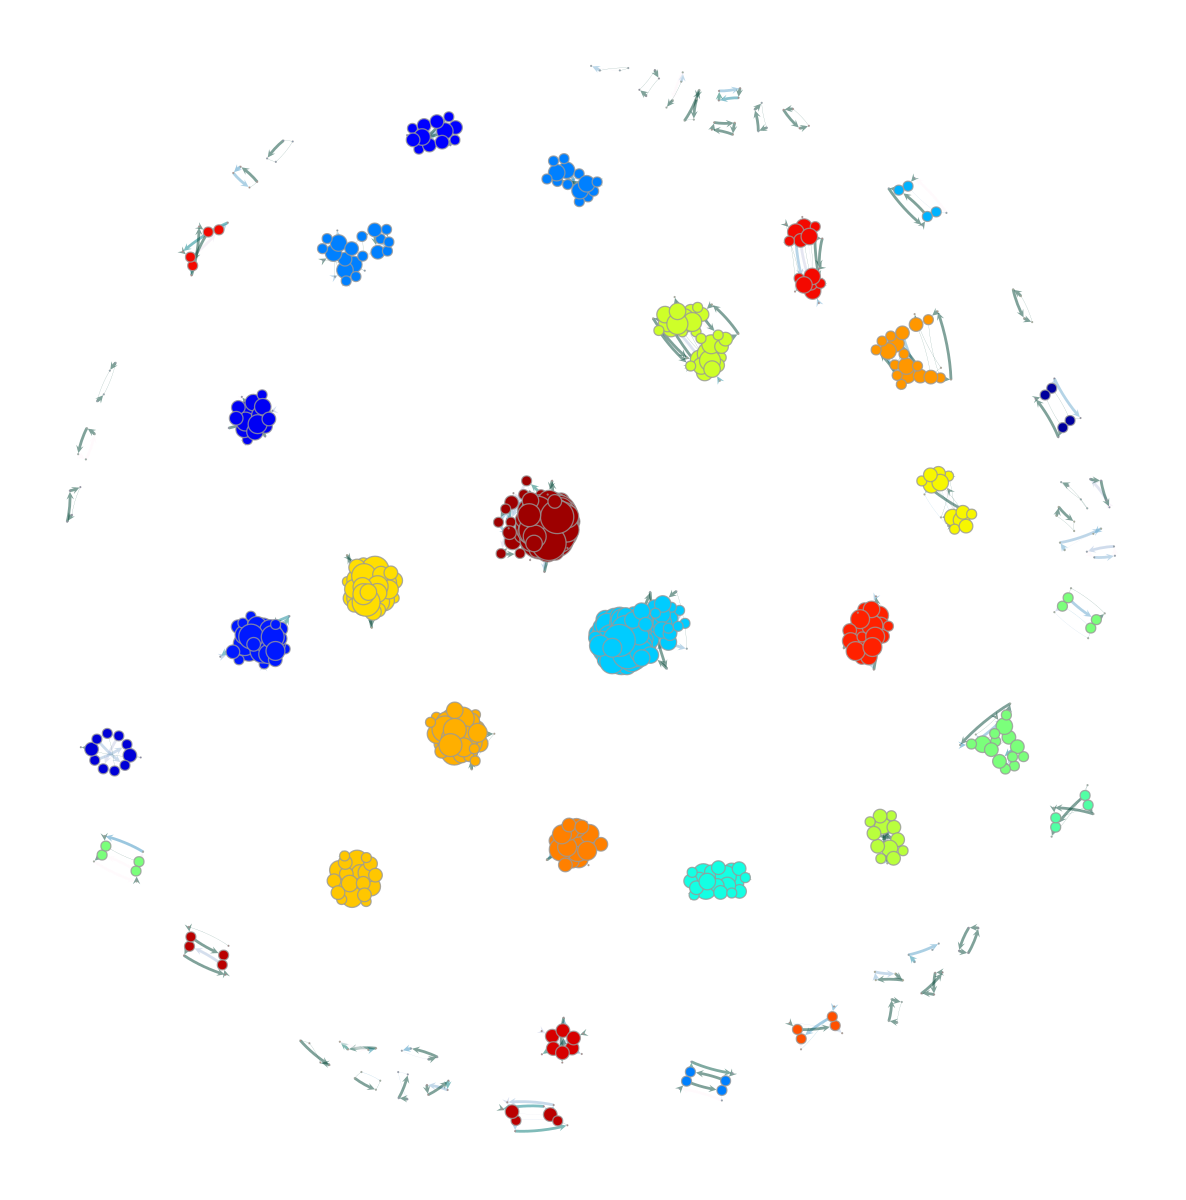

In [22]:
plot_network(rn.graph);

You'll notice that at this stage, the reaction network graph is a collection of "sub"-networks, i.e. a collection of smaller reaction networks for smaller chemical subsystems. This configuration will change once we set up for pathfinding in the next section.

The second way to plot graphs is to use graphistry, which requires setting up an account on Graphistry Hub: https://hub.graphistry.com/

In [23]:
plot_network_on_graphistry(rn.graph)

ValueError: In api=1 / api=2 mode, API key not set explicitly in `register()` or available at GRAPHISTRY_API_KEY

In [8]:
rn.set_precursors([entry_set.get_min_entry_by_formula("Li2CO3"), 
                   entry_set.get_min_entry_by_formula("Mn2O3"), 
                   entry_set.get_min_entry_by_formula("YCl3")])

In [17]:
rn.set_target("YMnO3")

In [8]:
### Solving for reaction pathways

In [18]:
paths = rn.find_pathways(["YMnO3", "LiCl", "CO2"], k=5)

PATHS to YMnO3 

--------------------------------------- 

Li2CO3 -> CO2 + Li2O (dG = 0.277 eV/atom) 
YCl3 + 1.5 Li2O -> 0.5 Y2O3 + 3 LiCl (dG = -0.297 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.789 

6 Mn2O3 -> O2 + 4 Mn3O4 (dG = 0.043 eV/atom) 
O2 + 2 YCl3 -> 2 YClO + 2 Cl2 (dG = 0.011 eV/atom) 
YClO + 0.3333 Mn2O3 -> 0.3333 YCl3 + 0.6667 YMnO3 (dG = 0.0 eV/atom) 
Total Cost: 0.808 

6 Mn2O3 -> O2 + 4 Mn3O4 (dG = 0.043 eV/atom) 
O2 + 1.333 YCl3 -> 2 Cl2 + 0.6667 Y2O3 (dG = 0.078 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.808 

Li2CO3 -> CO2 + Li2O (dG = 0.277 eV/atom) 
YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
YClO + 0.3333 Mn2O3 -> 0.3333 YCl3 + 0.6667 YMnO3 (dG = 0.0 eV/atom) 
Total Cost: 0.809 

Mn2O3 -> MnO + MnO2 (dG = 0.097 eV/atom) 
YCl3 + 1.5 MnO -> 0.5 Y2O3 + 1.5 MnCl2 (dG = 0.051 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.815 

PATHS to LiCl 

--------------------------------------

In [19]:
ps = PathwaySolver(rn.entries, paths, Softplus(900)) # open_elem="O", chempot=0

In [20]:
product_entries = []
for i in ["YMnO3","LiCl","CO2"]:
    product_entries.append(entry_set.get_min_entry_by_formula(i))
    
net_rxn = ComputedReaction.balance(rn.precursors,product_entries)
net_rxn

YCl3 + 0.5 Mn2O3 + 1.5 Li2CO3 -> YMnO3 + 3 LiCl + 1.5 CO2

In [21]:
a = ps.solve(net_rxn, max_num_combos=5, intermediate_rxn_energy_cutoff=0.0, filter_interdependent=True)

BasicEnumerator:   0%|          | 0/36 [00:00<?, ?it/s]

PathwaySolver:   0%|          | 0/1 [00:00<?, ?it/s]

PathwaySolver:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
for path in a:
    print(path)
    print("\n")

Li2CO3 -> CO2 + Li2O (dG = 0.277 eV/atom) 
Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
Li2CO3 + Mn2O3 -> CO2 + 2 LiMnO2 (dG = 0.08 eV/atom) 
LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
Average Cost: 0.267


Li2CO3 -> CO2 + Li2O (dG = 0.277 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
0.5 Li2O + YClO -> LiCl + 0.5 Y2O3 (dG = -0.136 eV/atom) 
Average Cost: 0.268


Li2CO3 -> CO2 + Li2O (dG = 0.277 eV/atom) 
1.5 Li2O + YCl3 -> 3 LiCl + 0.5 Y2O3 (dG = -0.297 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
0.5 Li2O + YClO -> LiCl + 0.5 Y2O3 (dG = -0.136 eV/atom) 
Average Cost: 0.274


Li2CO3 -> CO2 + Li2O (dG = 0.277 eV/atom) 
1.5 Li2O + YCl3 -> 3 LiCl + 0.5 Y2O3 (dG = -0.297 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Average Cost: 0.278


